# ***Georeferenciación de la tasa de deserción estudiantil en el sector oficial***

## ***1. Importar librerías***

En primer lugar se importan las librerías a usar en la actividad.

In [ ]:
import missingno as msno 
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import math
import warnings   
import geopandas as gpd

## ***2.Cargar shapefile***

Se define la ruta del archivo shapefile con `shapefile_path`, apuntando hacia un archivo .shp que contiene información geoespacial de los departamentos de Colombia. Finalmente, se carga ese archivo en un GeoDataFrame llamado `gdf` usando `gpd.read_file`, asegurando que los caracteres especiales se lean correctamente al especificar la codificación `utf-8`.


In [48]:
warnings.filterwarnings("ignore") 
shapefile_path = r"C:\Users\maria\OneDrive\Escritorio\Visualizacion_de_datos\MGN2021_DPTO_POLITICO\MGN_DPTO_POLITICO.shp"
gdf = gpd.read_file(shapefile_path, encoding='utf-8')

In [49]:
gdf.head()

,DPTO_CCDGO,DPTO_CNMBR,DPTO_ANO_C,DPTO_ACT_A,DPTO_NAREA,DPTO_CSMBL,DPTO_VGNC,Shape_Leng,Shape_Area,geometry
0,05,ANTIOQUIA,1886,Constitucion Politica de 1886,62808.629597,3,2021,21.492374,5.135236,"POLYGON ((-76.41355 8.87383, -76.40465 8.85195..."
1,08,ATLÁNTICO,1910,Ley 21 de 1910,3314.447413,3,2021,2.573162,0.273823,"POLYGON ((-74.84946 11.09778, -74.84938 11.097..."
2,11,"BOGOTÁ, D.C.",1538,Constitucion Politica de 1886,1622.852967,3,2021,3.765324,0.132208,"POLYGON ((-74.07059 4.82856, -74.07036 4.82856..."
3,13,BOLÍVAR,1886,Constitucion Politica de 1886,26719.968143,3,2021,16.233072,2.195639,"MULTIPOLYGON (((-76.17318 9.38785, -76.17287 9..."
4,15,BOYACÁ,1886,Constitucion Politica de 1886,23138.048132,3,2021,15.906491,1.888391,"POLYGON ((-72.17368 7.05308, -72.17277 7.05224..."


Observe que se llama al método `head()` sobre el GeoDataFrame `gdf`, lo que permite visualizar las primeras cinco filas del conjunto de datos cargado. Esta salida confirma que los datos se leyeron correctamente, mostrando columnas clave como el código y nombre del departamento, el año y acto legislativo de creación, el área en metros cuadrados, y campos geométricos como la longitud y el área de la figura. También se incluye el sistema de referencia y el año de la información geográfica. 


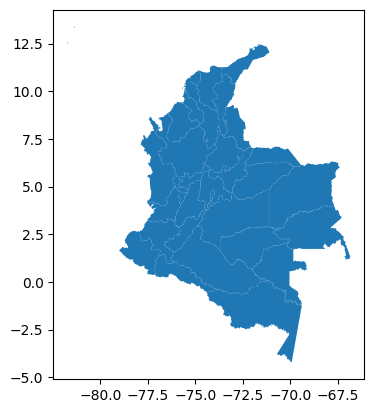

In [50]:
gdf.plot()
plt.show()

Observe que se utiliza el método `plot()` del GeoDataFrame `gdf` para generar una visualización del shapefile cargado anteriormente, que representa el mapa político de Colombia con sus divisiones departamentales. Luego, se llama a `plt.show()` para desplegar explícitamente la gráfica usando matplotlib. El resultado es una figura clara donde se visualizan los contornos de los departamentos del país, lo cual permite validar gráficamente que los datos geoespaciales fueron cargados correctamente y están listos para cruzarse con otros datos o usarse en análisis visuales.


## ***3. Cargar dataset***

En esta sección, se carga la base de datos del conyexto elegido.

In [51]:
df = pd.read_csv('MEN_ESTADISTICAS_EN_EDUCACION.csv', sep = ",")

In [52]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 37 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   AÑO                          429 non-null    int64  
 1   CÓDIGO_DEPARTAMENTO          429 non-null    int64  
 2   DEPARTAMENTO                 429 non-null    object 
 3   POBLACIÓN_5_16               429 non-null    int64  
 4   TASA_MATRICULACIÓN_5_16      429 non-null    object 
 5   COBERTURA_NETA               429 non-null    object 
 6   COBERTURA_NETA_TRANSICIÓN    429 non-null    object 
 7   COBERTURA_NETA_PRIMARIA      429 non-null    object 
 8   COBERTURA_NETA_SECUNDARIA    429 non-null    object 
 9   COBERTURA_NETA_MEDIA         429 non-null    object 
 10  COBERTURA_BRUTA              429 non-null    object 
 11  COBERTURA_BRUTA_TRANSICIÓN   429 non-null    object 
 12  COBERTURA_BRUTA_PRIMARIA     429 non-null    object 
 13  COBERTURA_BRUTA_SECU

Observe que se ha utilizado el método `.info()` para obtener una descripción general del DataFrame cargado anteriormente con estadísticas educativas. Esta salida muestra que el conjunto de datos tiene 429 filas y 37 columnas, todas con datos completos (sin valores nulos) excepto una: `SEDES_CONECTADAS_A_INTERNET`, que tiene 231 valores no nulos, lo que sugiere que habrá que tratar los valores faltantes si se piensa usar esta columna. También se puede ver el tipo de datos de cada columna, y destaca que la mayoría están clasificadas como `object`, lo cual es inadecuado para columnas que deberían ser numéricas, como tasas de cobertura o aprobación, por lo que probablemente será necesario convertirlas a `float` o `int` para poder hacer análisis cuantitativos. Además, se muestra el uso de memoria total del DataFrame, lo que ayuda a evaluar su tamaño y complejidad.


Ahora, debido a que el objetivo del la actividad es construit mapas coropléticos, seleccionaré las varianles relacionadas con la `deserción escolar` para darle un mejor enfoque a la actividad.

Se seleccionan las columnas del dataframe originsl con las que se trabajaré.

In [53]:
df = df[['AÑO', 'CÓDIGO_DEPARTAMENTO', 'DEPARTAMENTO', 'POBLACIÓN_5_16', 'DESERCIÓN', 'DESERCIÓN_TRANSICIÓN', 'DESERCIÓN_PRIMARIA', 'DESERCIÓN_SECUNDARIA', 'DESERCIÓN_MEDIA']]

In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 429 entries, 0 to 428
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   AÑO                   429 non-null    int64 
 1   CÓDIGO_DEPARTAMENTO   429 non-null    int64 
 2   DEPARTAMENTO          429 non-null    object
 3   POBLACIÓN_5_16        429 non-null    int64 
 4   DESERCIÓN             429 non-null    object
 5   DESERCIÓN_TRANSICIÓN  428 non-null    object
 6   DESERCIÓN_PRIMARIA    429 non-null    object
 7   DESERCIÓN_SECUNDARIA  429 non-null    object
 8   DESERCIÓN_MEDIA       429 non-null    object
dtypes: int64(3), object(6)
memory usage: 30.3+ KB


Observe que se vuelve a utilizar el método `.info()` para verificar la estructura del nuevo DataFrame reducido. Se confirma que contiene 429 registros y 9 columnas, y que no existen valores nulos. También se puede ver que algunas columnas importantes como población o tasas de deserción están en formato `object`, lo que sugiere que se podría necesitar conversión a tipos numéricos (`int` o `float`) antes de realizar análisis estadísticos o visualizaciones cuantitativas.


In [ ]:
df.columns = df.columns.str.lower().str.replace("ñ", "n")
df = df.applymap(lambda x: x.lower().replace("ñ", "n") if isinstance(x, str) else x)
df.columns = df.columns.str.replace(" ", "_")
from unidecode import unidecode

df.columns = [unidecode(col) for col in df.columns]

df = df.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)

Aquí se aplica una serie de transformaciones para limpiar tanto los nombres de las columnas como los valores tipo string dentro del DataFrame. Primero, se convierten todos los nombres de columnas a minúsculas, se reemplaza la letra ñ por n y se cambian los espacios por guiones bajos para facilitar su manipulación en el código. Luego, se utiliza la librería `unidecode` para eliminar tildes tanto en los nombres de columnas como en los registros de texto, asegurando homogeneidad en los datos y evitando errores por caracteres especiales en futuras operaciones de filtrado o fusión con otros conjuntos de datos.


## ***4. Verificar datos faltantes y duplicados***

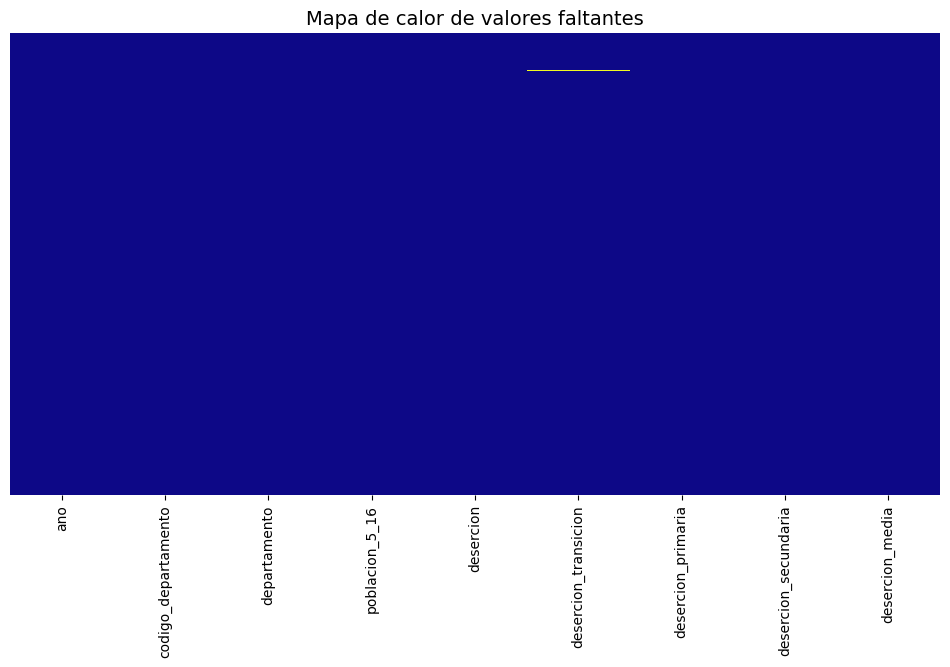

In [56]:
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, yticklabels=False, cmap='plasma')
plt.title("Mapa de calor de valores faltantes", fontsize=14)
plt.show()

La visualización revela que hay un único valor nulo en la columna `desercion_transicion`, ya que es la única que presenta una pequeña interrupción en su franja. Esta técnica es útil para detectar rápidamente si existe un problema de datos incompletos que deba corregirse antes del análisis.


In [57]:
faltantes = df.isnull().sum()
porcentaje = (faltantes / len(df)) * 100

tabla_faltantes = pd.DataFrame({
    'Valores faltantes': faltantes,
    'Porcentaje (%)': porcentaje
})

# Mostrar solo columnas con NA
tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

,Valores faltantes,Porcentaje (%)
desercion_transicion,1,0.2331


Observe que se realiza un conteo exacto de los valores faltantes por columna mediante `df.isnull().sum()` y luego se calcula el porcentaje que representan sobre el total de registros. Esta información se organiza en un nuevo DataFrame (`tabla_faltantes`), que muestra únicamente las columnas que tienen valores nulos. Al ordenar por porcentaje descendente, se confirma que solo hay un valor faltante en `desercion_transicion`, lo cual representa aproximadamente un 0.23% del total de registros, una proporción mínima que puede tratarse fácilmente sin comprometer el análisis.


In [58]:
df = df.dropna()

Aquí se toma la decisión de eliminar la fila que contiene el valor nulo utilizando `df.dropna()`. Dado que solo se trata de un registro faltante entre 429, esta acción es razonable y no afecta significativamente la integridad del conjunto de datos. Esta limpieza garantiza que no haya valores perdidos que puedan generar errores en etapas posteriores del análisis, como en cálculos estadísticos o visualizaciones.


In [ ]:
faltantes = df.isnull().sum()
porcentaje = (faltantes / len(df)) * 100

tabla_faltantes = pd.DataFrame({
    'Valores faltantes': faltantes,
    'Porcentaje (%)': porcentaje
})

tabla_faltantes = tabla_faltantes[tabla_faltantes['Valores faltantes'] > 0]
tabla_faltantes.sort_values('Porcentaje (%)', ascending=False)

,Valores faltantes,Porcentaje (%)


La tabla generada en esta ocasión no muestra columnas con valores faltantes, lo cual verifica que el DataFrame está limpio y completamente listo para el análisis.

## ***5. Merge de los datasets***

En esta sección se preparan los datos provenientes de dos fuentes distintas (el DataFrame `df` con estadísticas educativas y el GeoDataFrame `gdf` con información geográfica) para unirlos en un solo conjunto. Para que esta unión funcione correctamente, es necesario asegurar que las columnas por las cuales se va a hacer el emparejamiento (merge) estén estandarizadas en cuanto a nombres, tipo de datos, uso de tildes, mayúsculas y caracteres especiales. Aquí se inicia ese proceso de inspección y limpieza.

In [60]:
df['departamento']

0         antioquia
1         atlantico
2      bogota, d.c.
3           bolivar
4            boyaca
           ...     
424        amazonas
425         guainia
426        guaviare
427          vaupes
428         vichada
Name: departamento, Length: 428, dtype: object

Se visualiza la columna `departamento` del DataFrame `df`, que contiene los nombres de los departamentos en minúscula y sin tildes, gracias a las transformaciones realizadas anteriormente. 


In [61]:
gdf['DPTO_CNMBR']


0                                             ANTIOQUIA
1                                             ATLÁNTICO
2                                          BOGOTÁ, D.C.
3                                               BOLÍVAR
4                                                BOYACÁ
5                                                CALDAS
6                                               CAQUETÁ
7                                                 CAUCA
8                                                 CESAR
9                                               CÓRDOBA
10                                         CUNDINAMARCA
11                                                CHOCÓ
12                                                HUILA
13                                           LA GUAJIRA
14                                            MAGDALENA
15                                                 META
16                                               NARIÑO
17                                   NORTE DE SA

Se imprime la columna `DPTO_CNMBR` del GeoDataFrame `gdf`, que también contiene los nombres de los departamentos, pero en este caso están escritos en mayúsculas y con tildes. Este contraste con respecto a la columna `departamento` deja claro que ambas columnas, aunque contienen el mismo tipo de información, no están listas aún para usarse como clave de unión, por lo que es necesario aplicar transformaciones de formato y normalización textual para igualarlas.


In [ ]:
gdf.columns = gdf.columns.str.lower().str.replace("ñ", "n")
gdf = gdf.applymap(lambda x: x.lower().replace("ñ", "n") if isinstance(x, str) else x)
gdf.columns = gdf.columns.str.replace(" ", "_")
from unidecode import unidecode

gdf.columns = [unidecode(col) for col in gdf.columns]

gdf = gdf.applymap(lambda x: unidecode(x) if isinstance(x, str) else x)

Se realiza un proceso de limpieza y estandarización sobre el GeoDataFrame `gdf`, aplicando transformaciones similares a las que ya se hicieron en el DataFrame `df`. Se convierte todo el texto a minúsculas, se reemplaza la letra ñ por n, se eliminan espacios y tildes en los nombres de columnas y también en los valores de las celdas que sean tipo string. Esto asegura que ambas fuentes tengan un formato homogéneo y que la columna de nombres de departamentos esté lista para ser usada en una fusión sin errores de coincidencia textual.


In [63]:
df['departamento'].unique()

array(['antioquia', 'atlantico', 'bogota, d.c.', 'bolivar', 'boyaca',
       'caldas', 'caqueta', 'cauca', 'cesar', 'cordoba', 'cundinamarca',
       'choco', 'huila', 'la guajira', 'magdalena', 'meta', 'narino',
       'norte de santander', 'quindio', 'risaralda', 'santander', 'sucre',
       'tolima', 'valle del cauca', 'arauca', 'casanare', 'putumayo',
       'archipielago de san andres, providencia y santa catalina',
       'amazonas', 'guainia', 'guaviare', 'vaupes', 'vichada',
       'bogota, d,c,'], dtype=object)

Se listan los valores únicos de la columna `departamento` del DataFrame `df`, lo cual permite verificar cómo están escritos los nombres de los departamentos luego de las transformaciones aplicadas previamente. Esta revisión es clave para detectar inconsistencias o errores que podrían afectar el proceso de fusión con el otro dataset. En este caso, se observa que "bogota, d.c." aparece con una coma adicional que podría causar problemas al hacer el merge.


In [64]:
gdf['dpto_cnmbr'].unique()

array(['antioquia', 'atlantico', 'bogota, d.c.', 'bolivar', 'boyaca',
       'caldas', 'caqueta', 'cauca', 'cesar', 'cordoba', 'cundinamarca',
       'choco', 'huila', 'la guajira', 'magdalena', 'meta', 'narino',
       'norte de santander', 'quindio', 'risaralda', 'santander', 'sucre',
       'tolima', 'valle del cauca', 'arauca', 'casanare', 'putumayo',
       'archipielago de san andres, providencia y santa catalina',
       'amazonas', 'guainia', 'guaviare', 'vaupes', 'vichada'],
      dtype=object)

Se consultan los valores únicos de la columna `dpto_cnmb` del GeoDataFrame `gdf` para compararlos con los del DataFrame `df`. El objetivo es comprobar si existen diferencias textuales entre ambas columnas que impidan una correcta coincidencia. Aunque en general los nombres parecen coincidir, la comparación permite detectar con precisión casos puntuales como el de Bogotá, que requiere corrección.


In [65]:
df["departamento"] = df["departamento"].replace('bogota, d,c,', 'bogota, d.c.')

Se corrige explícitamente el valor mal formateado de "bogota, d.c.," en la columna `departamento` reemplazándolo por la forma correcta "bogota, d.c.". Esto resuelve el problema puntual detectado anteriormente y garantiza que el nombre del departamento coincida exactamente con el del shapefile, facilitando así una unión sin errores.


In [66]:
df['departamento']

0         antioquia
1         atlantico
2      bogota, d.c.
3           bolivar
4            boyaca
           ...     
424        amazonas
425         guainia
426        guaviare
427          vaupes
428         vichada
Name: departamento, Length: 428, dtype: object

Se imprime nuevamente la columna `departamento` para verificar que la corrección haya sido aplicada correctamente. Esta revisión confirma visualmente que el valor actualizado ya no contiene la coma adicional, lo que deja la columna lista para ser utilizada en la fusión con el GeoDataFrame.



In [67]:
df = df.rename(columns={"departamento": "dpto_cnmbr"})

Se renombra la columna `departamento` en el DataFrame `df` por `dpto_cnmb`, con el objetivo de que coincida exactamente en nombre con la columna homóloga del GeoDataFrame `gdf`. Esta es una práctica necesaria en pandas para realizar la operación de merge, ya que ambas columnas deben tener el mismo nombre para que se reconozcan como clave de unión.


In [68]:
data = pd.merge(gdf, df, on ='dpto_cnmbr', how = 'outer')

Se realiza la fusión final de los dos datasets, `df` y `gdf`, utilizando la columna `dpto_cnmb` como clave común. El tipo de unión especificado es `outer`, lo que significa que se conservarán todos los registros de ambos datasets, incluso si no tienen correspondencia directa. 

In [69]:
data.head()

,dpto_ccdgo,dpto_cnmbr,dpto_ano_c,dpto_act_a,dpto_narea,dpto_csmbl,dpto_vgnc,shape_leng,shape_area,geometry,ano,codigo_departamento,poblacion_5_16,desercion,desercion_transicion,desercion_primaria,desercion_secundaria,desercion_media
0,91,amazonas,1991,dcto. 2274 del 4 de octubre de la constitucion...,109497.053788,3,2021,25.355977,8.87748,"POLYGON ((-71.14469 0.05572, -71.14508 0.05349...",2011,91,22223,5.46%,5.56%,3.67%,8.21%,7.9%
1,91,amazonas,1991,dcto. 2274 del 4 de octubre de la constitucion...,109497.053788,3,2021,25.355977,8.87748,"POLYGON ((-71.14469 0.05572, -71.14508 0.05349...",2012,91,22194,4.7%,5.16%,2.3%,7.97%,8.06%
2,91,amazonas,1991,dcto. 2274 del 4 de octubre de la constitucion...,109497.053788,3,2021,25.355977,8.87748,"POLYGON ((-71.14469 0.05572, -71.14508 0.05349...",2013,91,22123,3.29%,3.16%,1.82%,5.26%,5.57%
3,91,amazonas,1991,dcto. 2274 del 4 de octubre de la constitucion...,109497.053788,3,2021,25.355977,8.87748,"POLYGON ((-71.14469 0.05572, -71.14508 0.05349...",2014,91,22167,3.04%,2.97%,1.95%,4.67%,4.35%
4,91,amazonas,1991,dcto. 2274 del 4 de octubre de la constitucion...,109497.053788,3,2021,25.355977,8.87748,"POLYGON ((-71.14469 0.05572, -71.14508 0.05349...",2015,91,22212,4.76%,4.54%,2.53%,8%,6.69%


Se muestra una vista previa de las primeras filas del nuevo DataFrame `data` resultante del merge entre el shapefile (`gdf`) y los datos educativos (`df`). A partir del resultado se puede comprobar que la unión se ha realizado correctamente, ya que se observan tanto columnas del shapefile (como `geometry`, `shape_area`, `dpto_cmnb`) como columnas propias del dataset educativo (`año`, `deserción`, `poblacion_5_16`, etc.). Esto indica que la información espacial y estadística ha sido correctamente integrada en un solo DataFrame.

In [70]:
data.tail()

,dpto_ccdgo,dpto_cnmbr,dpto_ano_c,dpto_act_a,dpto_narea,dpto_csmbl,dpto_vgnc,shape_leng,shape_area,geometry,ano,codigo_departamento,poblacion_5_16,desercion,desercion_transicion,desercion_primaria,desercion_secundaria,desercion_media
423,99,vichada,1991,5 de julio constitucion politica de 1991,100063.370595,3,2021,17.292613,8.10068,"POLYGON ((-67.80972 6.32432, -67.80946 6.32432...",2019,99,33198,7.63%,7%,7.45%,8.96%,4.78%
424,99,vichada,1991,5 de julio constitucion politica de 1991,100063.370595,3,2021,17.292613,8.10068,"POLYGON ((-67.80972 6.32432, -67.80946 6.32432...",2020,99,33298,3.07%,2.88%,3.09%,3.3%,2.17%
425,99,vichada,1991,5 de julio constitucion politica de 1991,100063.370595,3,2021,17.292613,8.10068,"POLYGON ((-67.80972 6.32432, -67.80946 6.32432...",2021,99,33183,5.02%,4.5%,4%,7.65%,6.18%
426,99,vichada,1991,5 de julio constitucion politica de 1991,100063.370595,3,2021,17.292613,8.10068,"POLYGON ((-67.80972 6.32432, -67.80946 6.32432...",2022,99,33949,6.58%,5.15%,6.38%,7.65%,6.11%
427,99,vichada,1991,5 de julio constitucion politica de 1991,100063.370595,3,2021,17.292613,8.10068,"POLYGON ((-67.80972 6.32432, -67.80946 6.32432...",2023,99,33816,6.8%,5.84%,6.78%,7.73%,4.54%


Se revisan las últimas filas del DataFrame `data` para confirmar que el contenido del merge también es consistente hacia el final de los registros. Los datos pertenecen al departamento de Vichada, con valores recientes hasta el año 2023, lo que demuestra que la cobertura temporal es amplia y actualizada. La visualización de estas filas permite identificar que no hay errores de unión ni registros vacíos al final del dataset.


In [71]:
data.columns

Index(['dpto_ccdgo', 'dpto_cnmbr', 'dpto_ano_c', 'dpto_act_a', 'dpto_narea',
       'dpto_csmbl', 'dpto_vgnc', 'shape_leng', 'shape_area', 'geometry',
       'ano', 'codigo_departamento', 'poblacion_5_16', 'desercion',
       'desercion_transicion', 'desercion_primaria', 'desercion_secundaria',
       'desercion_media'],
      dtype='object')

Se listan los nombres de las columnas del DataFrame `data`, lo cual es útil para tener claridad sobre la estructura final del conjunto de datos después del merge. Se puede observar que el DataFrame incluye información tanto administrativa (como códigos, nombres y geometría de los departamentos) como educativa (tasas de deserción por nivel, población escolar, etc.), lo que confirma que está listo para análisis posteriores como visualizaciones geoespaciales o modelado estadístico.


In [ ]:
data['ano'] = data['ano'].astype('object')
data['codigo_departamento'] = data['codigo_departamento'].astype('object')
data['dpto_cnmbr'] = data['dpto_cnmbr'].astype('object')
data['poblacion_5_16'] = data['poblacion_5_16'].astype('int')
data['codigo_departamento'] = data['codigo_departamento'].astype(str).str.zfill(2)


cols_porcentaje = [
    "desercion",
    "desercion_transicion",
    "desercion_primaria",
    "desercion_secundaria",
    "desercion_media"
]

for col in cols_porcentaje:
    data[col] = (
        data[col]
        .str.replace("%", "", regex=False)  
        .astype(float)                      
        / 100                               
    )


Se realiza la transformación de los tipos de datos en el DataFrame `data` para asegurar que las columnas relevantes tengan el formato correcto para análisis posteriores. La columna 'año' se convierte a tipo objeto para facilitar el filtrado por año, mientras que 'codigo_departamento' se estandariza en tipo string con relleno de ceros a la izquierda para asegurar uniformidad en los códigos. La población de 5 a 16 años se convierte a entero, y la columna de códigos del departamento se homogeniza en tipo objeto. Después, se define una lista con las columnas que contienen porcentajes de deserción escolar, se procede a limpiar el símbolo '%' y convertir esos valores a proporciones decimales dividiendo por 100, lo que es fundamental para trabajar con datos numéricos en modelos o visualizaciones sin errores de tipo.


In [73]:
data_2023 = data[data['ano'] == 2023]
data_2022 = data[data['ano'] == 2022]
data_2021 = data[data['ano'] == 2021]

Se filtra el DataFrame `data` para crear tres subconjuntos correspondientes a los años 2021, 2022 y 2023. Esto es útil para segmentar el análisis y comparar la evolución temporal de las variables relacionadas con la deserción escolar y población. Cada subconjunto contiene solo las filas correspondientes a su respectivo año, lo que facilita el análisis específico por periodo sin la necesidad de manipular el DataFrame completo.


## ***6. Mapa coroplético de la Tasa de deserción estudiantil en el sector oficial***

In [ ]:
def mapa(data, columna, titulo, col_nombres="dpto_cnmbr"):
    fig, ax = plt.subplots(1, 1, figsize=(16, 18))
    
    data.plot(
        column=columna,
        ax=ax,
        legend=True,
        legend_kwds={
            'label': columna,
            'orientation': "horizontal"
        }
    )

    for idx, row in data.iterrows():
        plt.text(
            row["geometry"].centroid.x,
            row["geometry"].centroid.y,
            str(row[col_nombres]),
            fontsize=6,
            ha="center"
        )
    
    plt.title(titulo, fontsize=18)
    plt.axis('off')
    plt.show()


### ***6.1. Tasa de deserción escolar por Departamento en 2021***

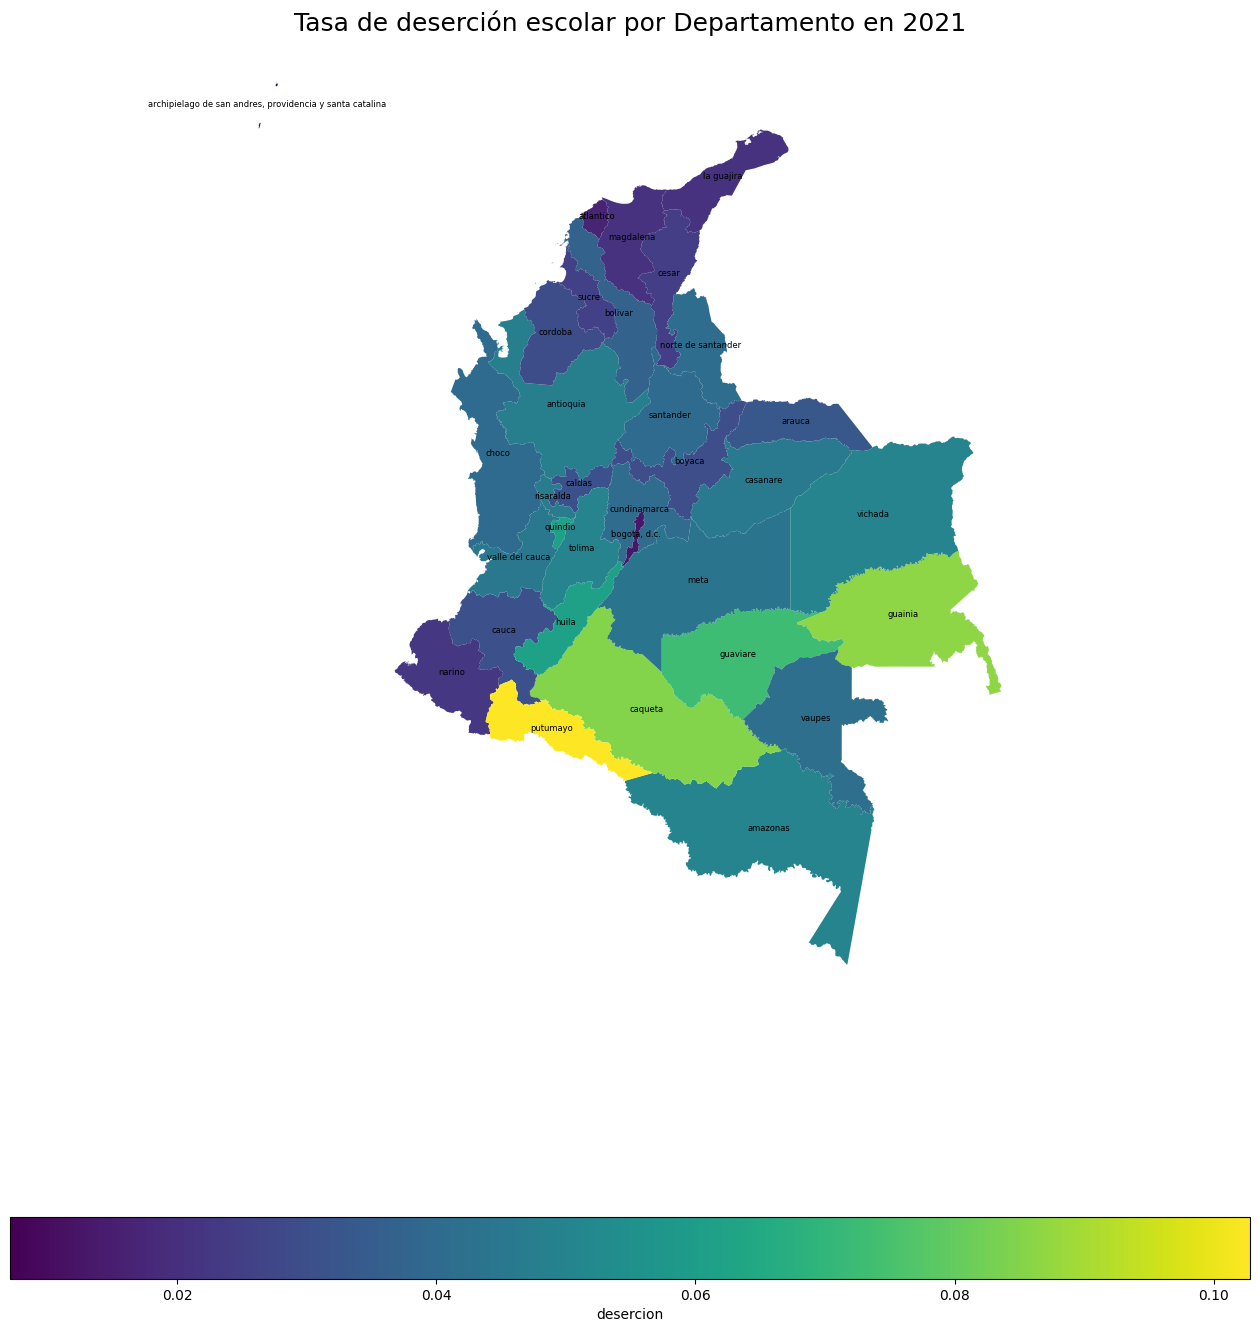

In [84]:
mapa(data_2021, 'desercion', 'Tasa de deserción escolar por Departamento en 2021')


El mapa muestra claramente que la tasa de deserción escolar en 2021 varía significativamente entre los departamentos de Colombia. Las zonas con colores más oscuros, principalmente en el norte y algunas partes del centro, indican tasas bajas de deserción, mientras que los departamentos en el sur, como Putumayo y Caquetá, presentan las tasas más altas, reflejadas en colores amarillos y verdes claros. Esto sugiere que las regiones más alejadas o con condiciones socioeconómicas posiblemente más complejas enfrentan mayores dificultades para mantener a los estudiantes en el sistema educativo. La disparidad regional en la deserción escolar evidencia la necesidad de enfoques diferenciados para combatir este problema según las particularidades de cada departamento.


### ***6.2. Tasa de deserción escolar por Departamento en 2022***

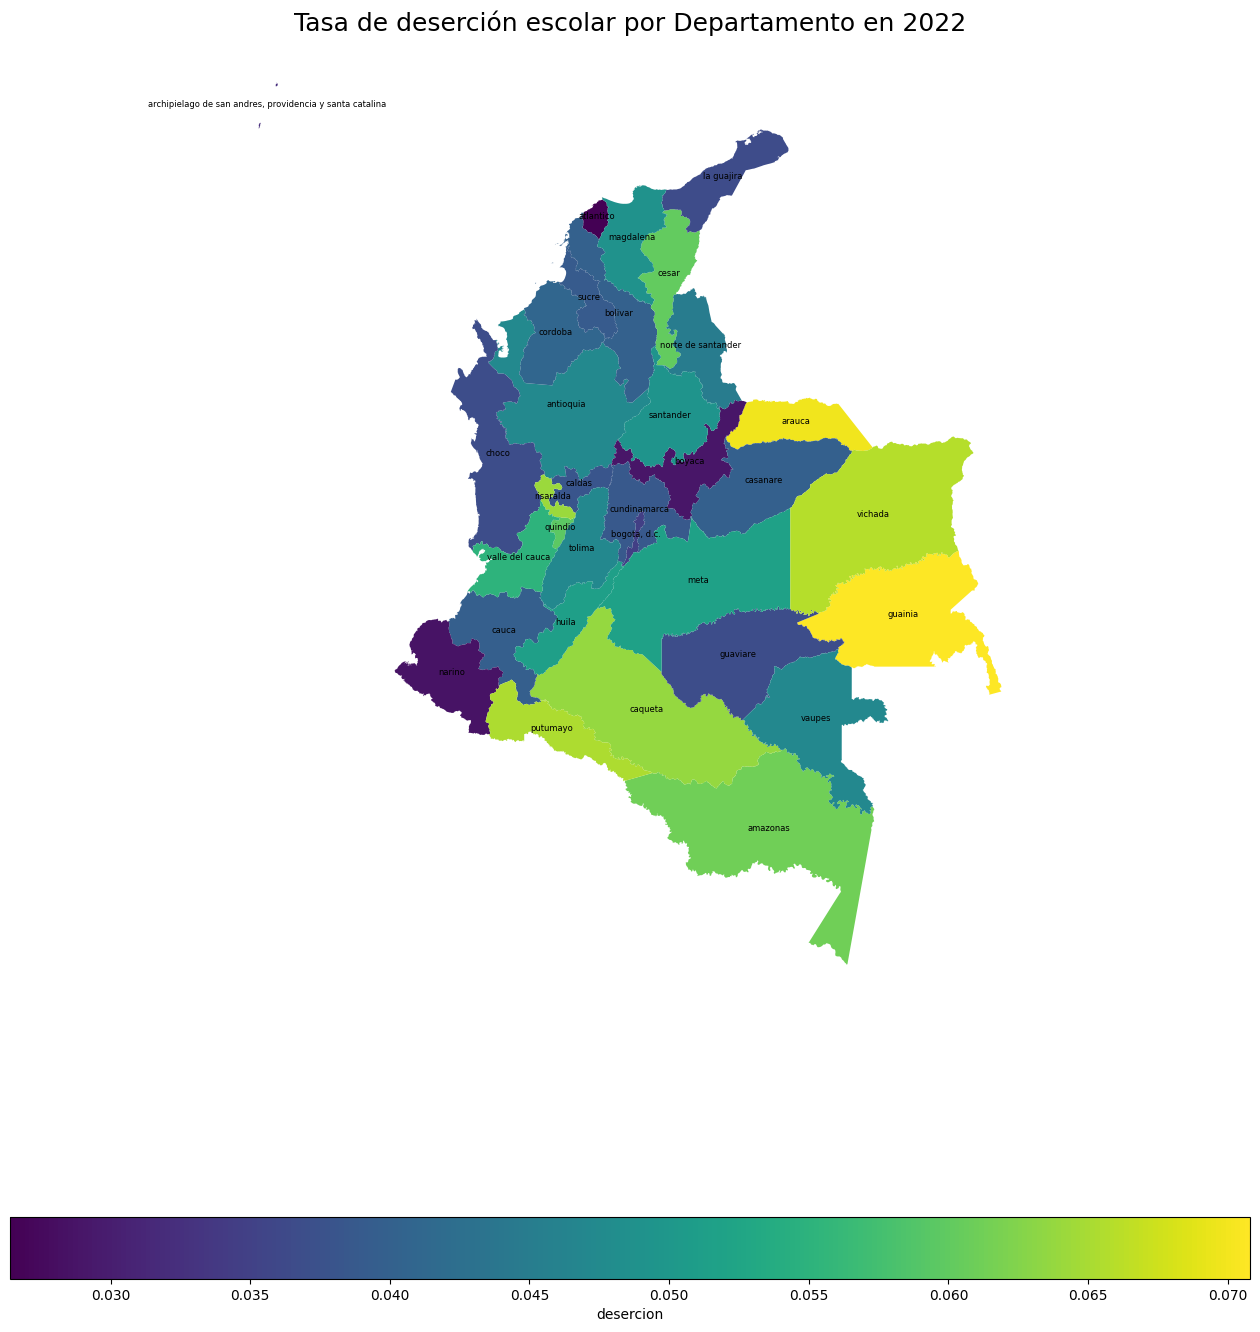

In [75]:
mapa(data_2022, 'desercion', 'Tasa de deserción escolar por Departamento en 2022')

Este mapa presenta la tasa de deserción escolar por departamento en 2022 y muestra un patrón similar al del año anterior, con variaciones notables en algunos departamentos. Se observa que departamentos como Guainía y Arauca mantienen altas tasas de deserción, reflejadas en tonos amarillos, mientras que la región norte y algunas partes del centro del país presentan tasas más bajas, evidenciadas por colores más oscuros. Hay departamentos como Antioquia y Valle del Cauca que muestran una mejora relativa en comparación con 2021, con colores más cercanos a los tonos azules, indicando menor deserción. Esto puede sugerir que ciertas políticas o intervenciones podrían estar funcionando en algunas regiones, aunque sigue existiendo una disparidad clara en la deserción escolar entre las diferentes zonas del país.


### ***6.3. Tasa de deserción escolar por Departamento en 2023***

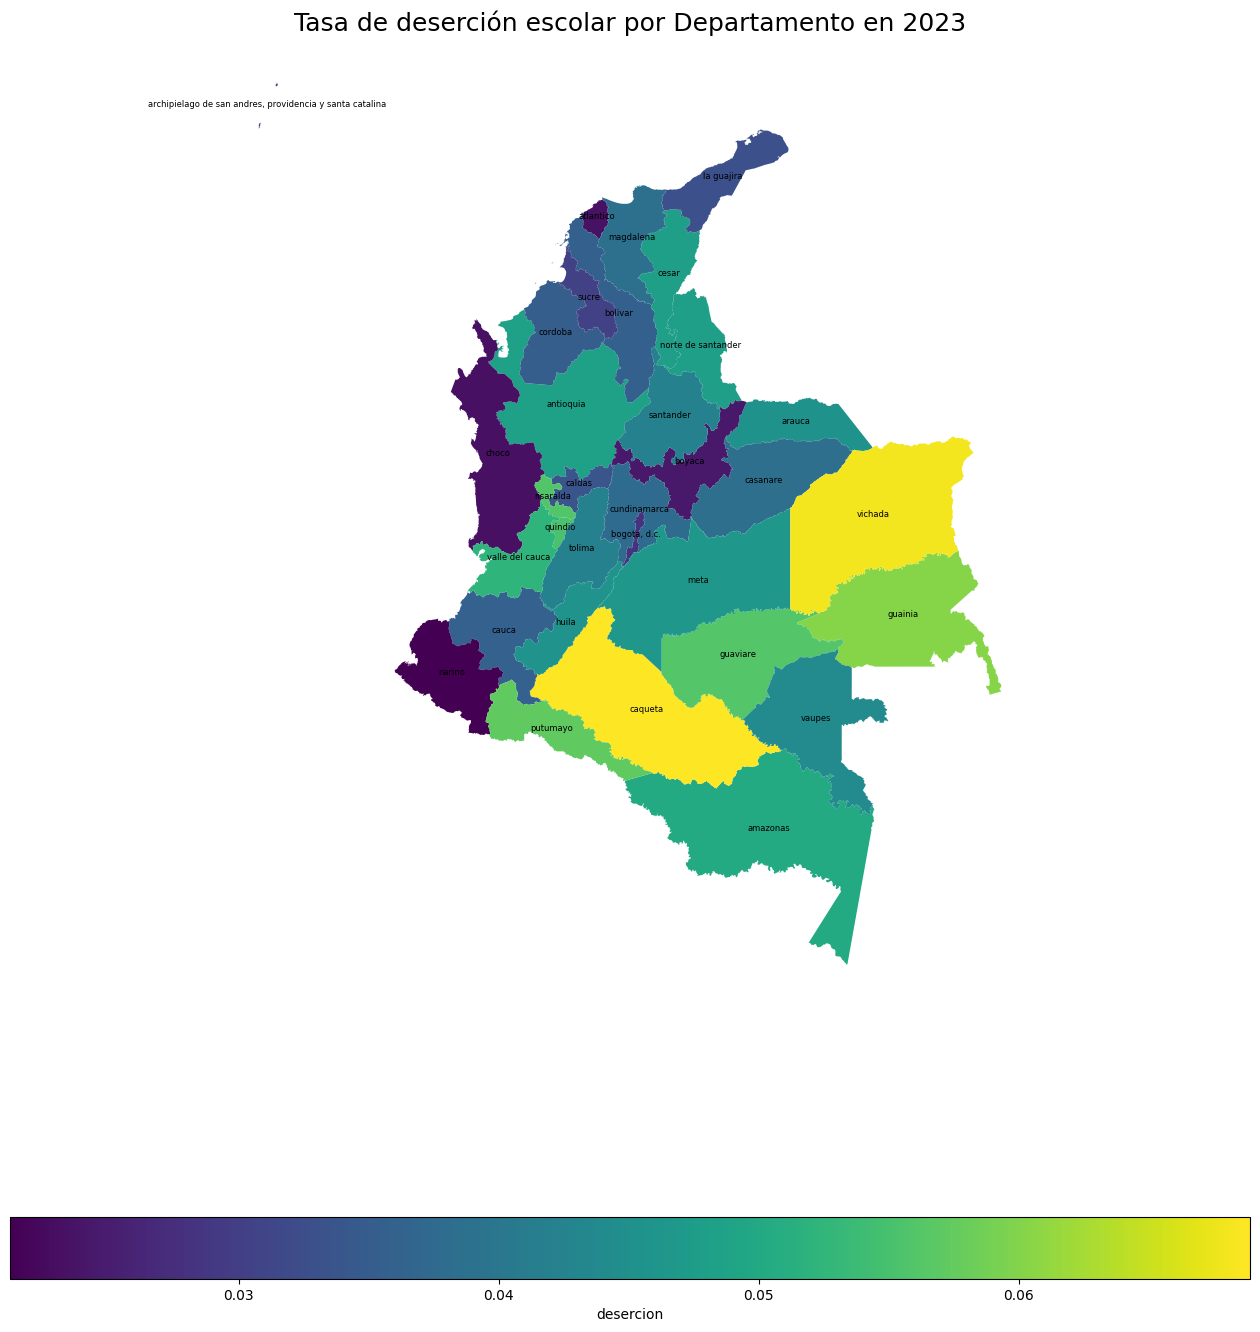

In [76]:
mapa(data_2023, 'desercion', 'Tasa de deserción escolar por Departamento en 2023')

Se observa que los departamentos con tasas más altas de deserción escolar, marcados en amarillo, son Caquetá y Vichada, lo que indica que en estos lugares la cantidad de estudiantes que abandonan el sistema educativo es relativamente mayor. En contraste, departamentos como Chocó, Nariño y Boyacá presentan tasas muy bajas, señaladas con tonos morados, sugiriendo mejores niveles de retención escolar. La mayor parte del centro del país, incluyendo Bogotá, Cundinamarca y Antioquia, tiene tasas moderadas, con colores verde-azulados, lo que refleja una situación intermedia en cuanto a deserción. Este patrón puede estar influenciado por factores socioeconómicos, geográficos y de acceso a servicios educativos, ya que las zonas con mayor deserción suelen corresponder a regiones con condiciones más desfavorables o de difícil acceso.


### ***6.4. Mapa coroplético de la Tasa de deserción estudiantil en el sector oficial según el nivel de estudio***

Debido a que, como se obsservó anteriormente, en el año 2022 se presentaron tasas más altas de deserción, se observará la tasa de deserción según la etapa escolar: transición, primaria, secundaria y media.

#### ***6.4.1. Tasa de deserción escolar en el nivel educativo transición por Departamento en 2022***

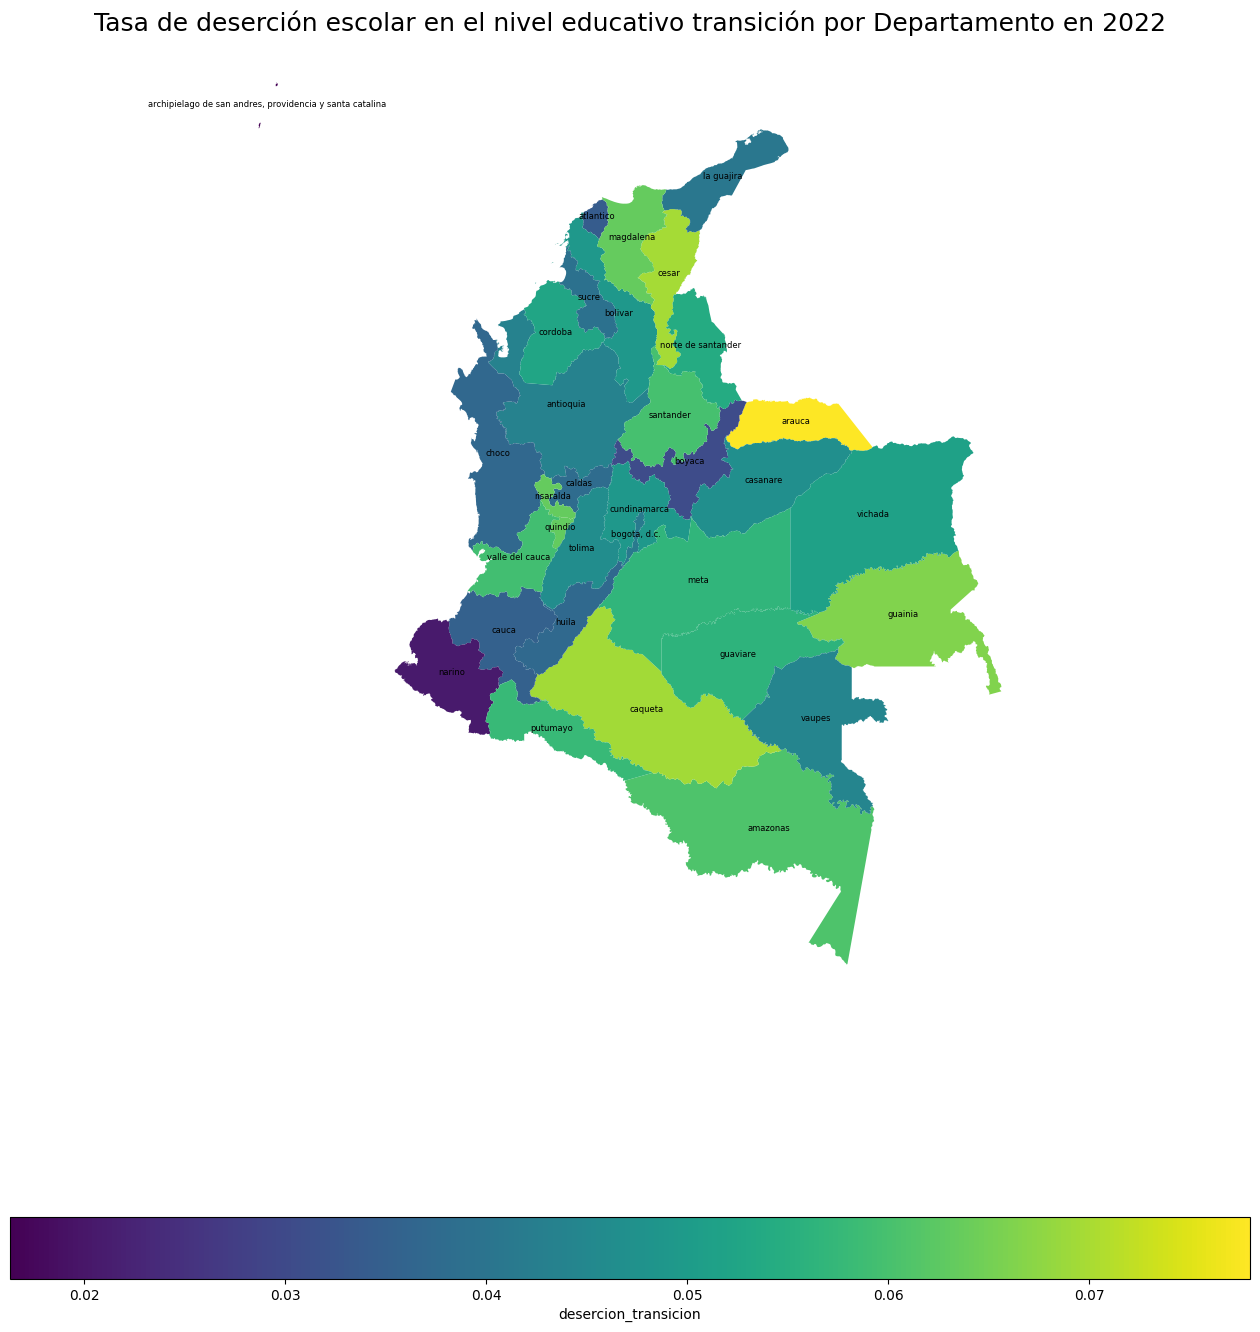

In [77]:
mapa(data_2022, 'desercion_transicion', 'Tasa de deserción escolar en el nivel educativo transición por Departamento en 2022')

Se aprecia que departamentos como Nariño, Quindío, y Chocó presentan las tasas más bajas de deserción en transición, con colores que se acercan al extremo izquierdo de la escala, reflejando valores cercanos o por debajo del 2%. En contraste, departamentos como Arauca y Caquetá destacan con tasas altas, evidenciadas por los tonos amarillos intensos que superan el 7%. El centro del país, incluyendo Bogotá, Cundinamarca y Santander, muestra tasas intermedias, lo que sugiere una situación de deserción menos crítica pero aún presente. En el oriente del país, Vichada y Guainía también presentan valores relativamente altos. Este patrón geográfico sugiere que los territorios más apartados o con menor desarrollo institucional pueden estar enfrentando mayores dificultades para garantizar la permanencia de los niños en esta primera etapa del sistema educativo formal.

#### ***6.4.2. Tasa de deserción escolar en el nivel educativo primeraia por Departamento en 2022***

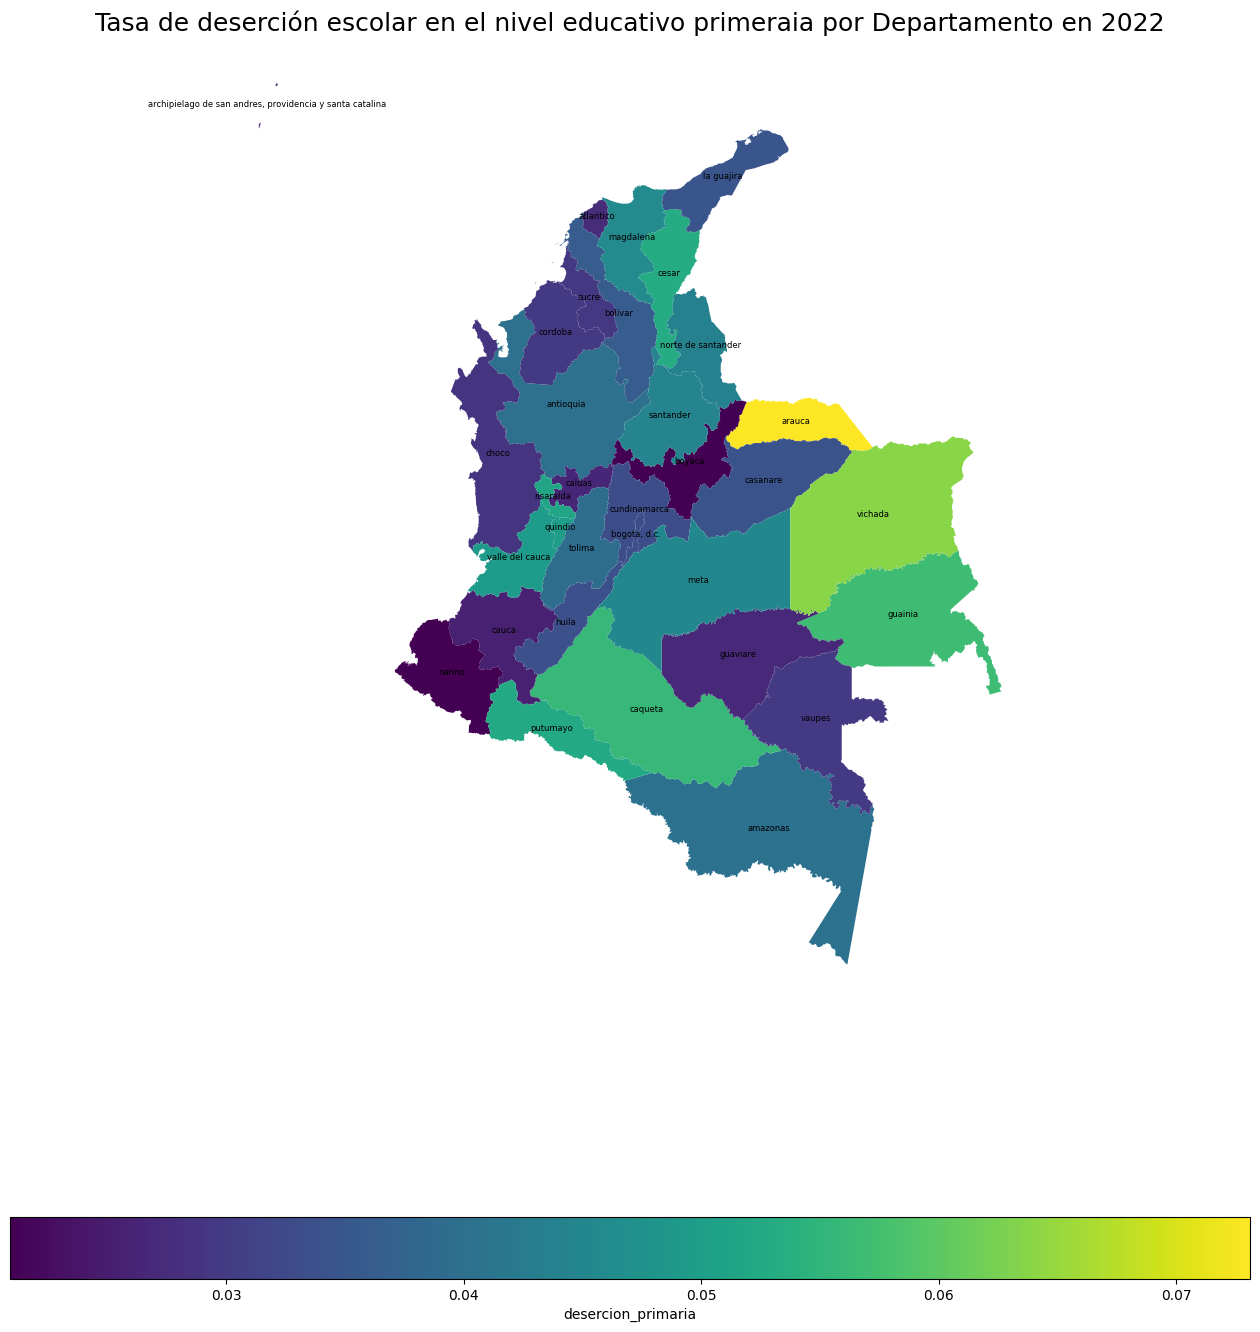

In [81]:
mapa(data_2022, 'desercion_primaria', 'Tasa de deserción escolar en el nivel educativo primeraia por Departamento en 2022')

Se identifica que la mayoría de los departamentos se concentran en rangos bajos a medios, con una presencia marcada de colores morados y azul oscuro, especialmente en regiones como Nariño, Chocó, Quindío, Boyacá, y Antioquia, lo que sugiere un buen nivel de permanencia estudiantil en esta etapa del sistema educativo. Arauca vuelve a destacar negativamente, con una tasa considerablemente alta, evidenciada por un color amarillo brillante que indica una deserción cercana o superior al 7%. Vichada también muestra una tasa elevada, mientras que regiones del sur como Caquetá y Putumayo reflejan niveles medios. En general, el patrón espacial sugiere que, aunque la mayoría del país mantiene tasas relativamente bajas de deserción en primaria, todavía existen zonas críticas en el oriente del país donde el abandono escolar sigue siendo un desafío importante en esta etapa educativa clave.


#### ***6.4.3. Tasa de deserción escolar en el nivel educativo secundaria por Departamento en 2022***

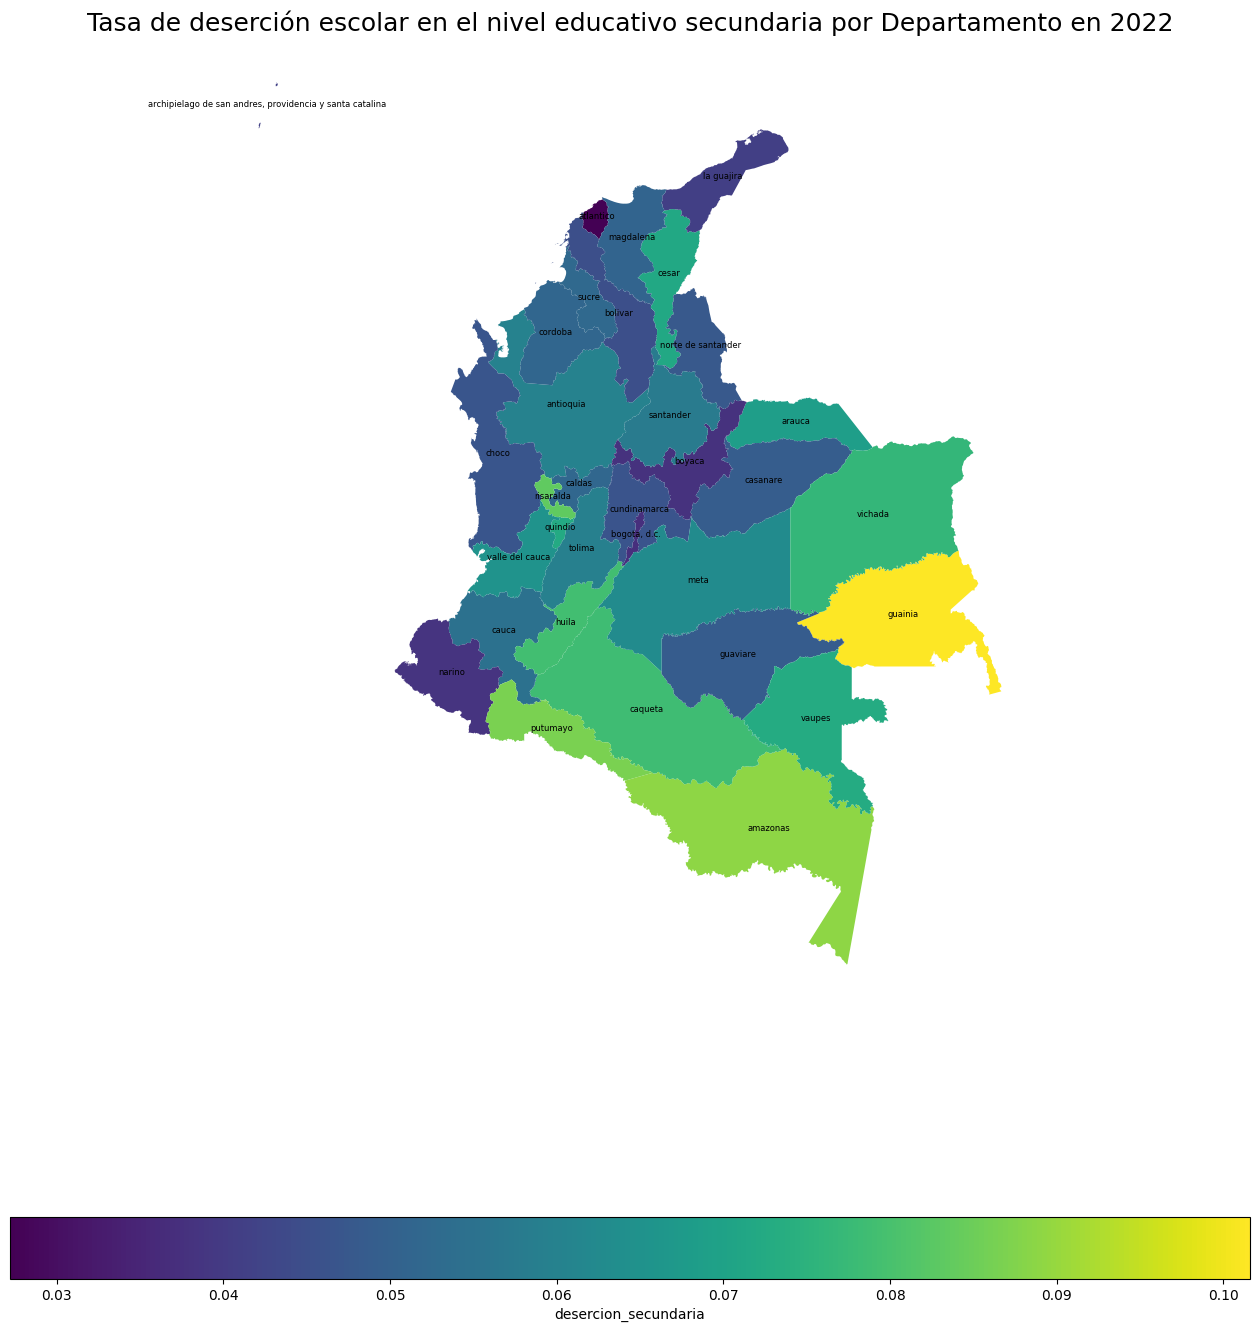

In [83]:
mapa(data_2022, 'desercion_secundaria', 'Tasa de deserción escolar en el nivel educativo secundaria por Departamento en 2022')

En este mapa se representa la tasa de deserción escolar en el nivel de secundaria por departamento en Colombia para el año 2022. Guainía destaca de forma evidente con una de las tasas de deserción más altas del país en secundaria, superando el 10%, seguida por departamentos como Amazonas y Caquetá, que también presentan valores altos reflejados en tonos verdes claros y amarillos. En contraste, regiones como Bogotá, Boyacá, Santander, Nariño y Chocó se mantienen en rangos bajos, evidenciados por tonalidades moradas, lo cual indica una retención escolar relativamente favorable en esa etapa. La tendencia general muestra que la deserción tiende a aumentar en las zonas más periféricas o con menor cobertura educativa continua, lo que sugiere que las barreras de acceso, permanencia o calidad del servicio educativo se acentúan en la medida en que los estudiantes avanzan hacia niveles superiores como la secundaria.


#### ***6.4.4. Tasa de deserción escolar en el nivel educativo media por Departamento en 2022***

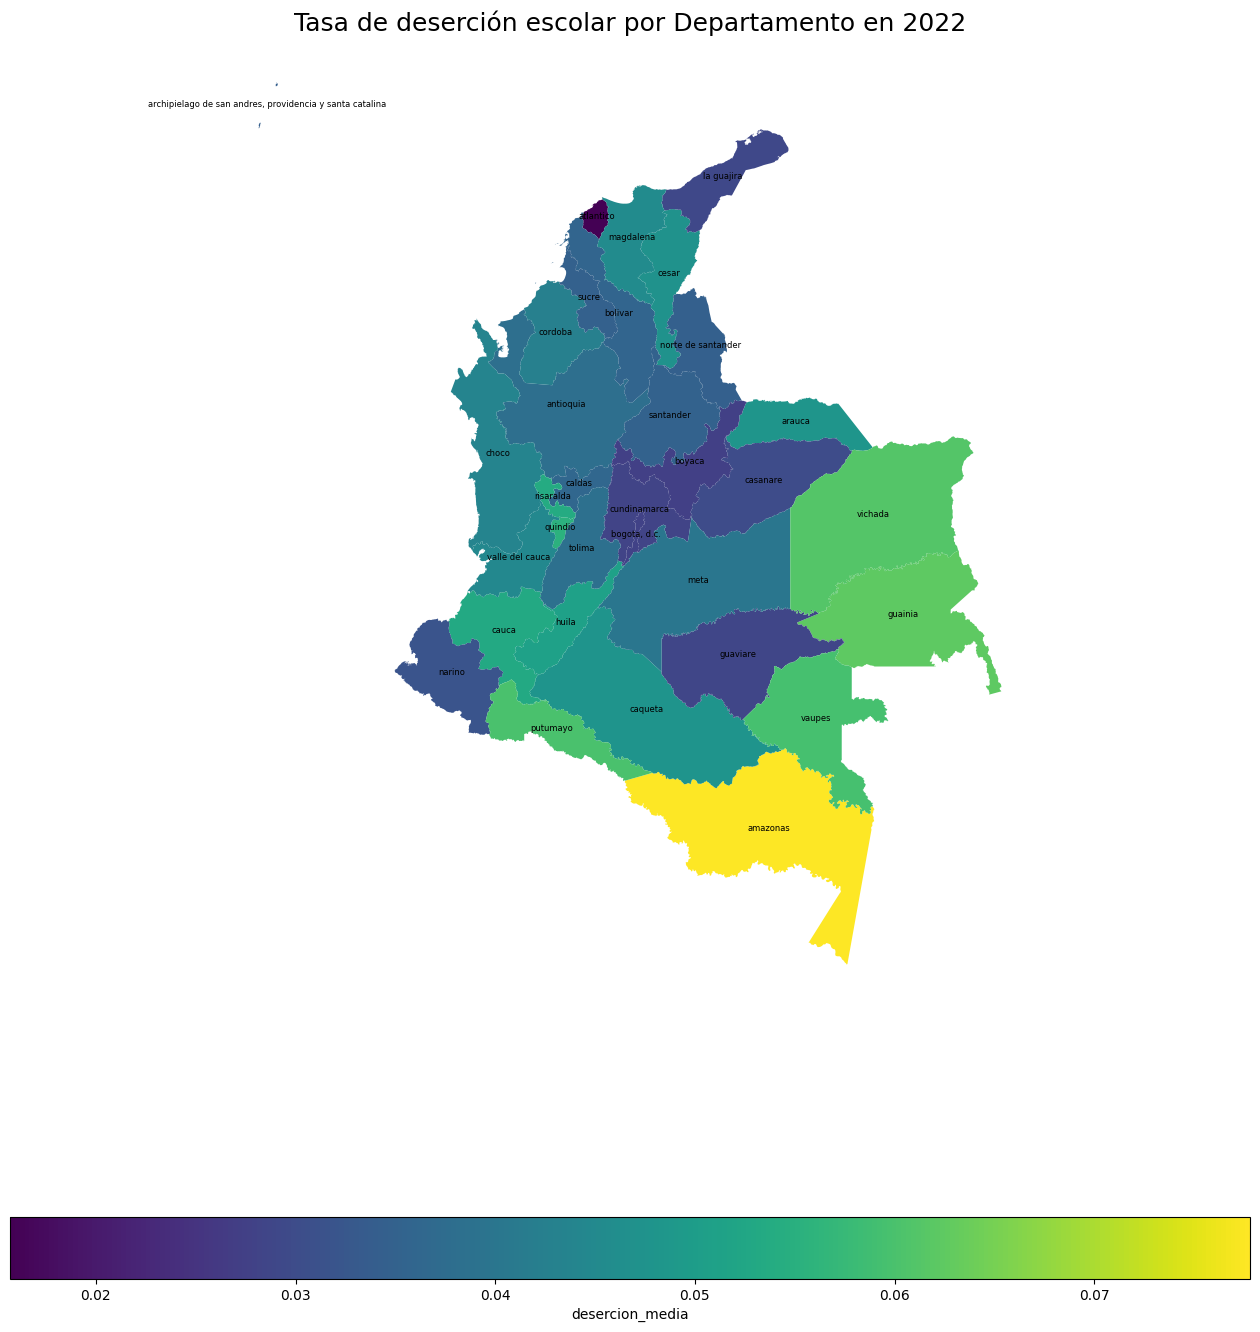

In [ ]:
mapa(data_2022, 'desercion_media', 'Tasa de deserción escolar en el nivel educativo media por Departamento en 2022')

Este mapa presenta la tasa de deserción escolar en el nivel de educación media por departamento en Colombia durante el año 2022, utilizando una escala de color que va del morado (tasas más bajas) al amarillo (tasas más altas). Se observa que el departamento de Amazonas resalta con la mayor tasa de deserción en el país, claramente visible en un tono amarillo intenso que indica un valor superior al 7%. También se identifican niveles elevados en Caquetá y Putumayo, mientras que departamentos del centro como Bogotá, Cundinamarca, y algunos del Caribe como Atlántico y Bolívar, presentan tasas significativamente más bajas, lo cual se refleja en colores morados y azul oscuro. Magdalena, en contraste con sus vecinos, también destaca con una tasa alta que no es común en la región norte. En general, la tendencia muestra que, en esta etapa final del sistema escolar, los niveles de abandono aumentan en regiones más periféricas o con limitaciones estructurales para garantizar continuidad educativa, lo que podría estar asociado a factores como la necesidad de ingresar al mercado laboral, baja oferta de media académica o técnica, o dificultades socioeconómicas locales.
